## Zooniverse Analysis

In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import seaborn as sns
from lsst.ap.association import UnpackApdbFlags, MapDiaSourceConfig


In [52]:
dfzoo = pd.read_csv('alert-production-zoo-classifications.csv')

In [53]:
len(dfzoo)

386

In [54]:
dfzoo.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,207552876,ebellm,1649740.0,bcb090b573bb93a473ab,13338,Scan cutouts,14.25,2020-03-07 01:13:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938231"":{""retired"":null,""diaSourceId"":1764...",40938231
1,207552908,ebellm,1649740.0,bcb090b573bb93a473ab,13338,Scan cutouts,14.25,2020-03-07 01:13:13 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938233"":{""retired"":null,""diaSourceId"":1764...",40938233
2,207553020,ebellm,1649740.0,bcb090b573bb93a473ab,13338,Scan cutouts,14.25,2020-03-07 01:13:44 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938229"":{""retired"":null,""diaSourceId"":1764...",40938229
3,207553077,ebellm,1649740.0,bcb090b573bb93a473ab,13338,Scan cutouts,14.25,2020-03-07 01:14:00 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938219"":{""retired"":null,""diaSourceId"":1764...",40938219
4,207553107,ebellm,1649740.0,bcb090b573bb93a473ab,13338,Scan cutouts,14.25,2020-03-07 01:14:09 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938221"":{""retired"":null,""diaSourceId"":1764...",40938221


In [55]:
def get_classification(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[0]['value'])

def get_text_comment(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[1]['value'] if (x[0]['value'] == 'Other') else None)

def get_diaSourceId(df):
    return dfzoo['subject_data'].apply(json.loads).apply(lambda x: list(x.values())[0]['diaSourceId'])

In [56]:
dfzoo['classification'] = get_classification(dfzoo)
dfzoo['comment'] = get_text_comment(dfzoo)
dfzoo['diaSourceId'] = get_diaSourceId(dfzoo)

Foolishly we mixed HSC and DECam data, and for some reason it doesn't seem like the subject sets are made distinct.  I think I should have used some additional keys, not just the diaSourceID.

Thankfully there's no overlap in diaSourceId

In [41]:
REPO = '/project/mrawls/hits2015/rerun/decorr_2020_03'
connection = sqlite3.connect(f'{REPO}/association.db')
diaSources = pd.read_sql_query('select * from DiaSource', connection)

In [42]:
#REPO = '/project/mrawls/cosmos/rerun/ap_pipe-g-1'
#connection = sqlite3.connect(f'{REPO}/association.db')
#hscDiaSources = pd.read_sql_query('select * from DiaSource', connection)
#np.intersect1d(diaSources.diaSourceId.values,hscDiaSources.diaSourceId.values)

In [43]:
diaSources = pd.merge(diaSources,dfzoo[['classification','comment','diaSourceId']],on='diaSourceId',how='inner')

In [44]:
len(diaSources)

214

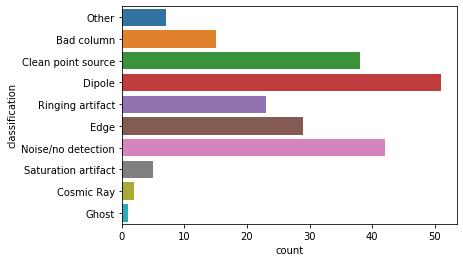

In [45]:
sns.countplot(data=diaSources,y='classification')

In [46]:
# what about those no-detections?
wnodet = diaSources['classification'] == 'Noise/no detection'

In [50]:
diaSources.loc[wnodet,'apFlux'].head()

14    1868.158490
19    2378.102988
25     190.532576
27    -699.935586
52   -2704.782024
Name: apFlux, dtype: float64

In [48]:
# via https://github.com/lsst-dm/ap_pipe-notebooks/blob/master/false_positives/False-Positive-Census.ipynb
config = MapDiaSourceConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(diaSources['flags'], 'flags')
flag_names = list(flag_values.dtype.names)
labels = ['baseFlag', 'offImage', 'edge', 'interp', 'saturated', 'CR', 'bad', 'suspect', 
          'interpCen', 'saturatedCen', 'CRCen', 'suspectCen', 
          'centroidFlag', 'centroidPosFlag', 'centroidNegFlag',
          'apFluxFlag', 'apTruncated', 'psfFluxFlag', 'noGoodPixels', 'psfFluxFlagEdge',
          'diffimForcedFlag', 'diffimForcedNoGoodPixels', 'diffimForcedEdge', 
          'shapeFlag', 'shapeUnweightedBad', 'shapeUnweighted', 'shapeShift', 'shapeMaxIter', 'shapePsf']

/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/ap_association/19.0.0-13-g744ec97+5/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [30]:
flag_names

['base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_saturated',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_suspectCenter',
 'slot_Centroid_flag',
 'slot_Centroid_pos_flag',
 'slot_Centroid_neg_flag',
 'slot_ApFlux_flag',
 'slot_ApFlux_flag_apertureTruncated',
 'slot_PsfFlux_flag',
 'slot_PsfFlux_flag_noGoodPixels',
 'slot_PsfFlux_flag_edge',
 'ip_diffim_forced_PsfFlux_flag',
 'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
 'ip_diffim_forced_PsfFlux_flag_edge',
 'slot_Shape_flag',
 'slot_Shape_flag_unweightedBad',
 'slot_Shape_flag_unweighted',
 'slot_Shape_flag_shift',
 'slot_Shape_flag_maxIter',
 'slot_Shape_flag_psf']

In [57]:
flagTable = pd.DataFrame(flag_values, index=diaSources.index)
diaSources = diaSources.join(flagTable)

In [32]:
flagTable

,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
0,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,True,True,False,False,False,False
1,False,False,False,True,False,False,True,True,True,False,...,False,False,False,False,True,True,False,False,False,False
2,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,True,False,False,True,False,False
3,False,False,True,True,True,True,False,False,True,True,...,False,False,False,False,True,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
210,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,True,False,False
211,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
212,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


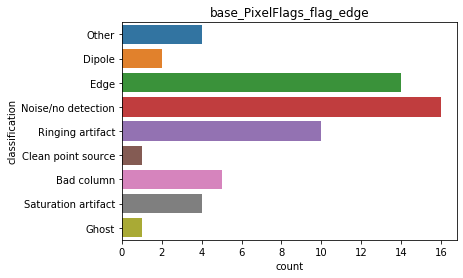

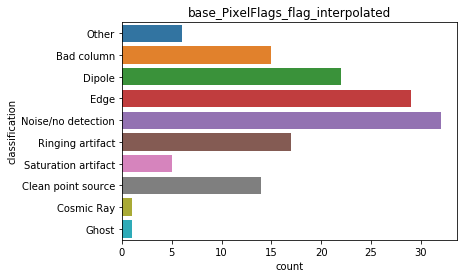

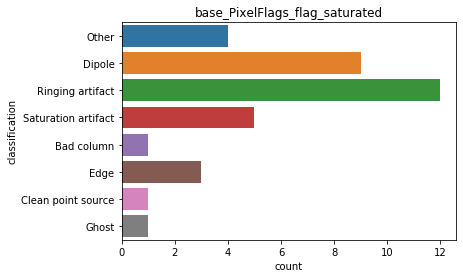

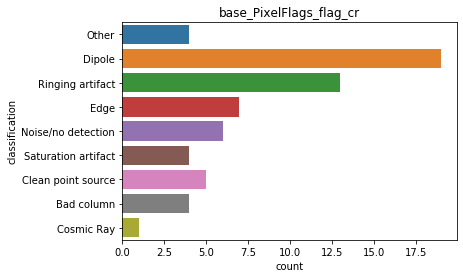

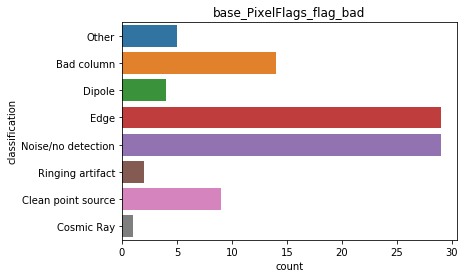

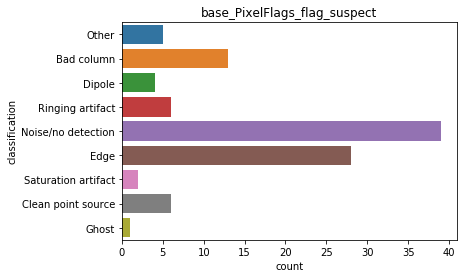

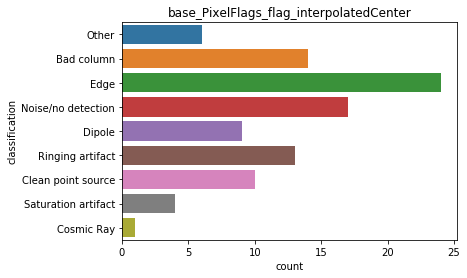

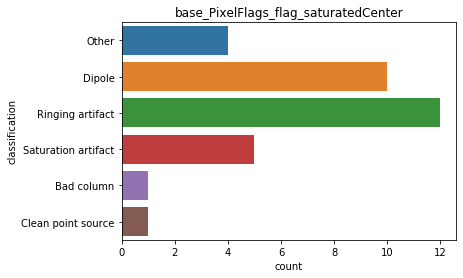

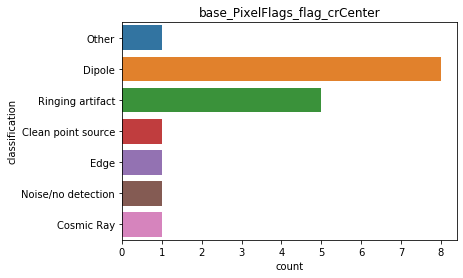

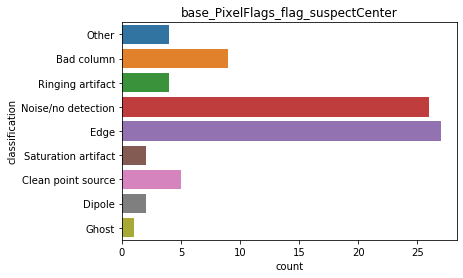

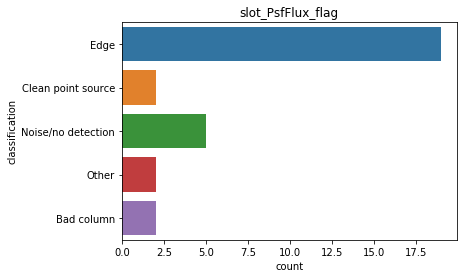

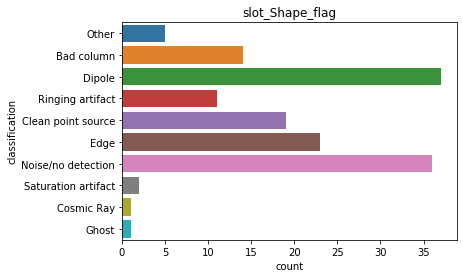

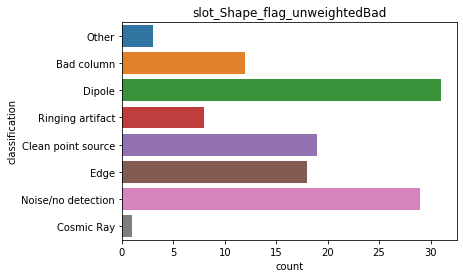

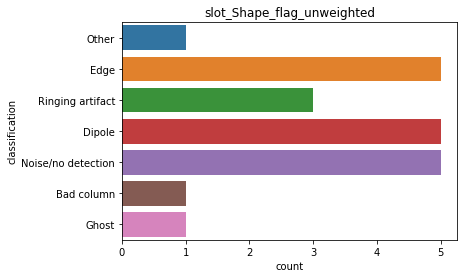

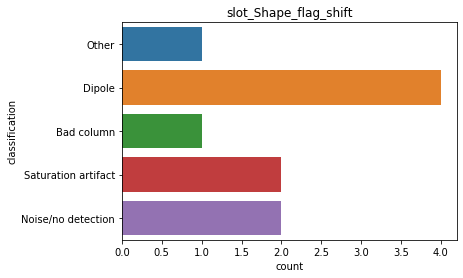

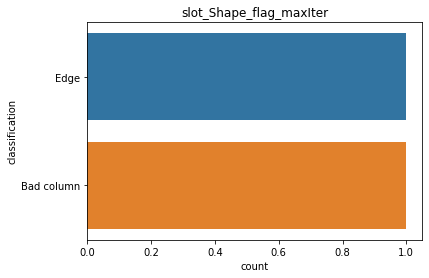

In [59]:
for name in flag_names:
    w = diaSources.loc[:,name]
    if np.sum(w):
        fig = plt.figure()
        sns.countplot(data=diaSources.loc[w,:],y='classification')
        plt.title(name)

In [91]:
classgrp = diaSources.groupby('classification')
flag_pct_byclass = classgrp[flag_names].agg(lambda x: (np.sum(x)/len(x)).astype(float))
flag_pct_byclass

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
classification,,,,,,,,,,,,,,,,,,,,,
Bad column,False,False,0.333333,1.000000,0.066667,0.266667,0.933333,0.866667,0.933333,0.066667,...,False,False,False,False,0.933333,0.800000,0.066667,0.066667,0.066667,False
Clean point source,False,False,0.026316,0.368421,0.026316,0.131579,0.236842,0.157895,0.263158,0.026316,...,False,False,False,False,0.500000,0.500000,0.000000,0.000000,0.000000,False
Cosmic Ray,False,False,0.000000,0.500000,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,...,False,False,False,False,0.500000,0.500000,0.000000,0.000000,0.000000,False
Dipole,False,False,0.039216,0.431373,0.176471,0.372549,0.078431,0.078431,0.176471,0.196078,...,False,False,False,False,0.725490,0.607843,0.098039,0.078431,0.000000,False
Edge,False,False,0.482759,1.000000,0.103448,0.241379,1.000000,0.965517,0.827586,0.000000,...,False,False,False,False,0.793103,0.620690,0.172414,0.000000,0.034483,False
Ghost,False,False,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,False,False,False,False,1.000000,0.000000,1.000000,0.000000,0.000000,False
Noise/no detection,False,False,0.380952,0.761905,0.000000,0.142857,0.690476,0.928571,0.404762,0.000000,...,False,False,False,False,0.857143,0.690476,0.119048,0.047619,0.000000,False
Other,False,False,0.571429,0.857143,0.571429,0.571429,0.714286,0.714286,0.857143,0.571429,...,False,False,False,False,0.714286,0.428571,0.142857,0.142857,0.000000,False
Ringing artifact,False,False,0.434783,0.739130,0.521739,0.565217,0.086957,0.260870,0.565217,0.521739,...,False,False,False,False,0.478261,0.347826,0.130435,0.000000,0.000000,False


/home/ebellm/.local/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: cannot perform reduce with flexible type

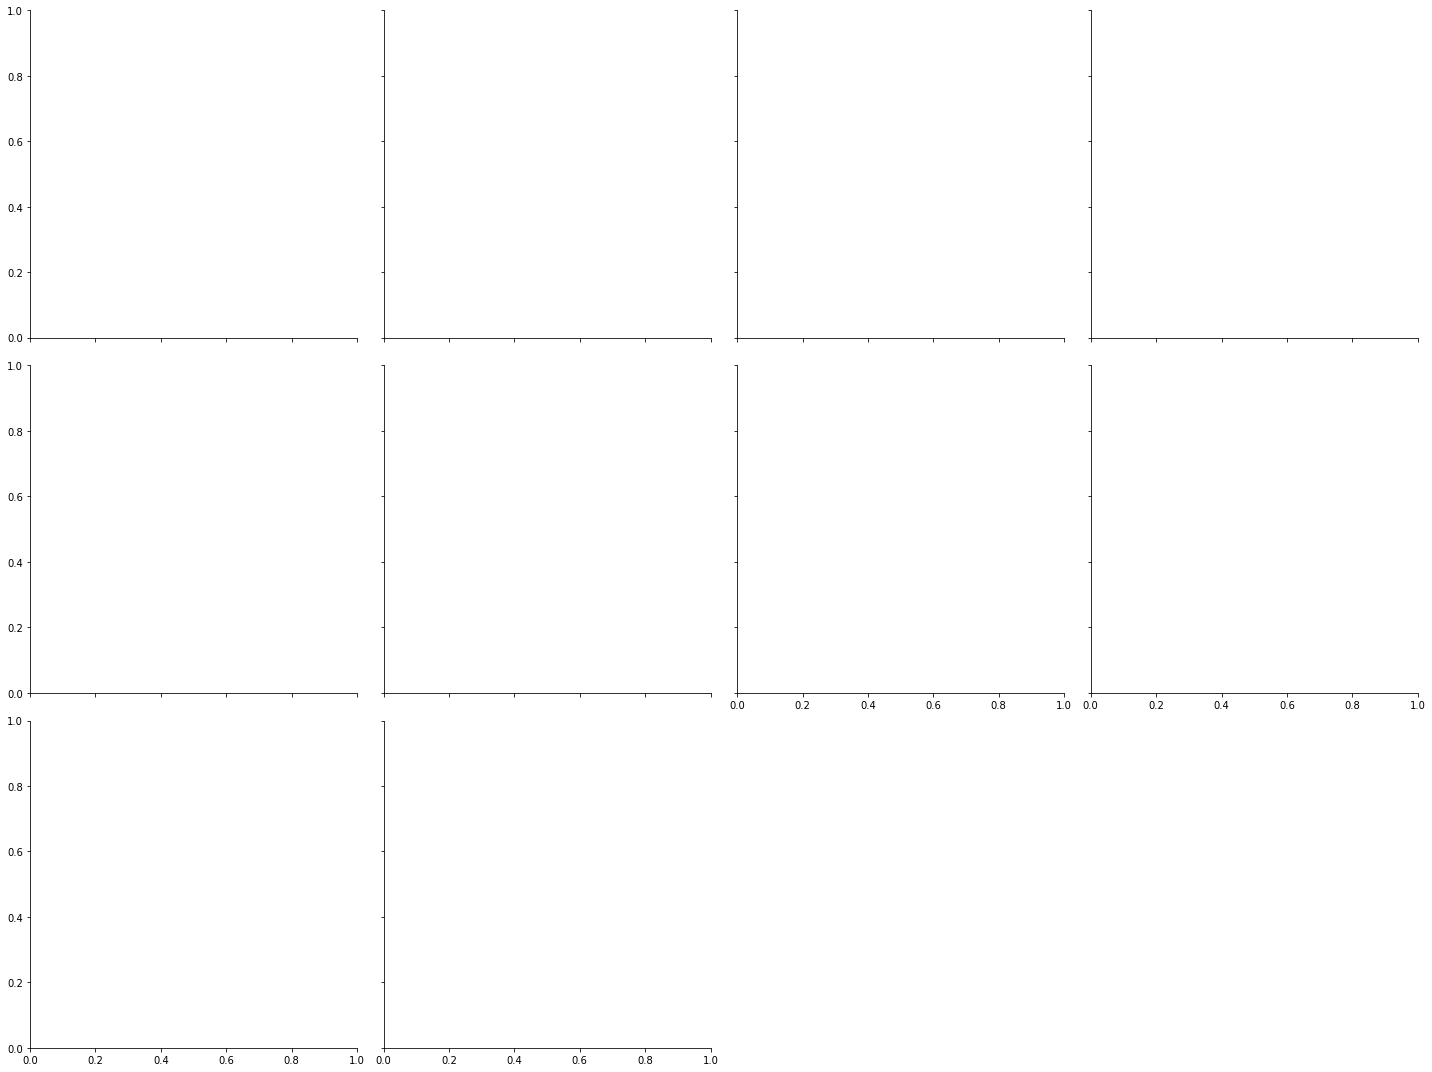

In [81]:
grid = sns.FacetGrid(flag_pct_byclass.reset_index(), col="classification",  palette="tab20c",
                     col_wrap=4, height=5)
grid.map(sns.barplot,y=flag_names)

Formal requirements are on SNR > 6 (note these are *measured* SNRs not detected which is why this looks weird)

In [108]:
diaSources['snr'] = diaSources['apFlux']/diaSources['apFluxErr']

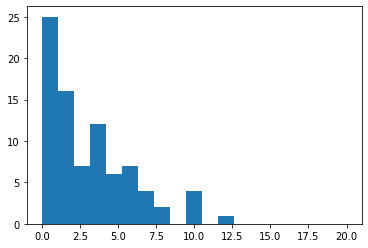

In [99]:
_=plt.hist(diaSources.snr,bins=np.linspace(0,20,20))

In [102]:
wsnrgt6 = diaSources.snr >= 6
np.sum(wsnrgt6)

46

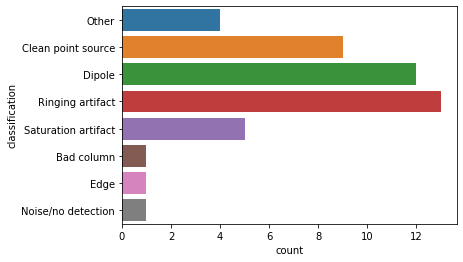

In [103]:
sns.countplot(data=diaSources.loc[wsnrgt6,:],y='classification')

artifact to real ratios:

In [109]:
np.sum(wsnrgt6 & ~(diaSources.classification == 'Clean point source')) / \
np.sum(wsnrgt6 & (diaSources.classification == 'Clean point source'))

4.111111111111111

In [110]:
np.sum(~(diaSources.classification == 'Clean point source')) / \
np.sum((diaSources.classification == 'Clean point source'))

4.631578947368421